In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 80% !important; }</style>"))

In [2]:
# import warnings
# warnings.filterwarnings("default")

In [3]:
import sys
import time
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import colors

In [4]:
myColors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
            '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
            '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
            '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', 
            '#307D7E', '#000000', "#DDEFFF", "#000035", "#7B4F4B", 
            "#A1C299", "#300018", "#C2FF99", "#0AA6D8", "#013349", 
            "#00846F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", 
            "#1E6E00", "#DFFB71", "#868E7E", "#513A01", "#CCAA35"]

colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [5]:
import smashpy
sf = smashpy.smashpy()

 * Initialising ...



# Loading annData object

In [7]:
obj = sc.read_h5ad('../../../External_datasets/mouse_brain_all_cells_20200625_with_annotations.h5ad')
obj.X = obj.X.toarray()
obj = obj[obj.obs["Cell broad annotation"]!='Unk']

In [8]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 39583 cells


In [9]:
obj.var.set_index(obj.var["SYMBOL"], inplace=True, drop=False)
obj.var.index.name = None

#### Data preparation

In [10]:
sf.data_preparation(obj)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


#### Data split

In [11]:
s = time.time()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
data = obj.X.copy()

myDict = {}
for idx, c in enumerate(obj.obs["Cell broad annotation"].cat.categories):
    myDict[c] = idx

labels = []
for l in obj.obs["Cell broad annotation"].tolist():
    labels.append(myDict[l])

labels = np.array(labels)

X = data
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### RankCorr

In [14]:
sys.path.append("../../../Functions/RankCorr/")
from picturedRocks import Rocks

In [15]:
genes = obj.var.index.tolist()

In [16]:
data = Rocks(X_train, y_train)
markers = data.CSrankMarkers(lamb=3.0, writeOut=False, keepZeros=False, onlyNonZero=False)
data.genes = np.array(genes)

In [17]:
marker_genes = data.markers_to_genes(markers)

In [18]:
selectedGenes = [x for x in marker_genes if x != 'nan'][:30]

In [19]:
selectedGenes_dict = {}
selectedGenes_dict["group"] = selectedGenes

In [20]:
e = time.time()

#### Classifiers

<Figure size 432x288 with 0 Axes>

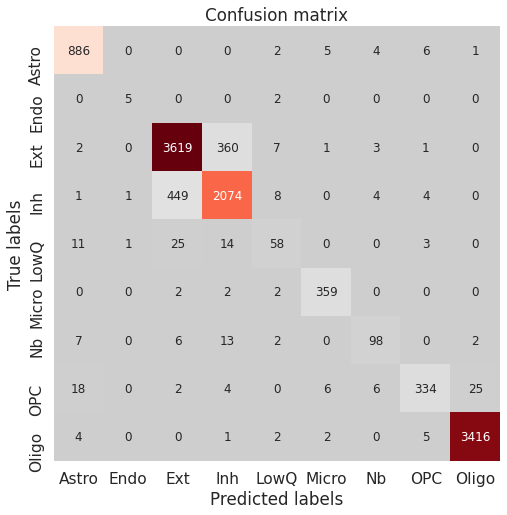

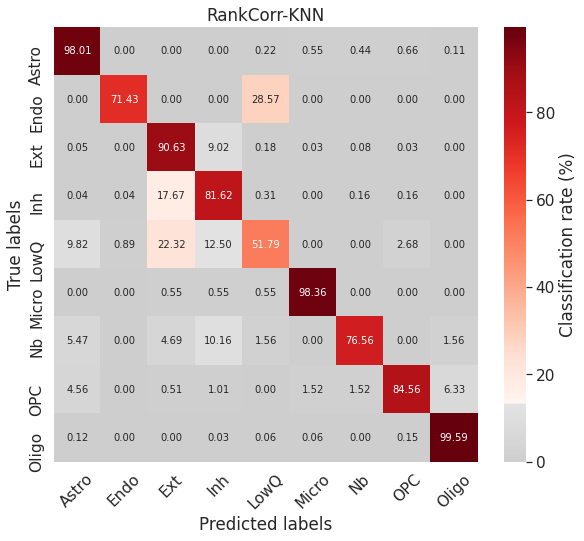

Accuracy: 0.9136: Misclassification: 0.08640000000000003
              precision    recall  f1-score   support

       Astro       0.95      0.98      0.97       904
        Endo       0.71      0.71      0.71         7
         Ext       0.88      0.91      0.89      3993
         Inh       0.84      0.82      0.83      2541
        LowQ       0.70      0.52      0.59       112
       Micro       0.96      0.98      0.97       365
          Nb       0.85      0.77      0.81       128
         OPC       0.95      0.85      0.89       395
       Oligo       0.99      1.00      0.99      3430

    accuracy                           0.91     11875
   macro avg       0.87      0.84      0.85     11875
weighted avg       0.91      0.91      0.91     11875



In [21]:
sf.run_classifiers(obj, group_by="Cell broad annotation", genes=selectedGenes, classifier="KNN", balance=True, title="RankCorr-KNN")

#### Heatmap selected genes

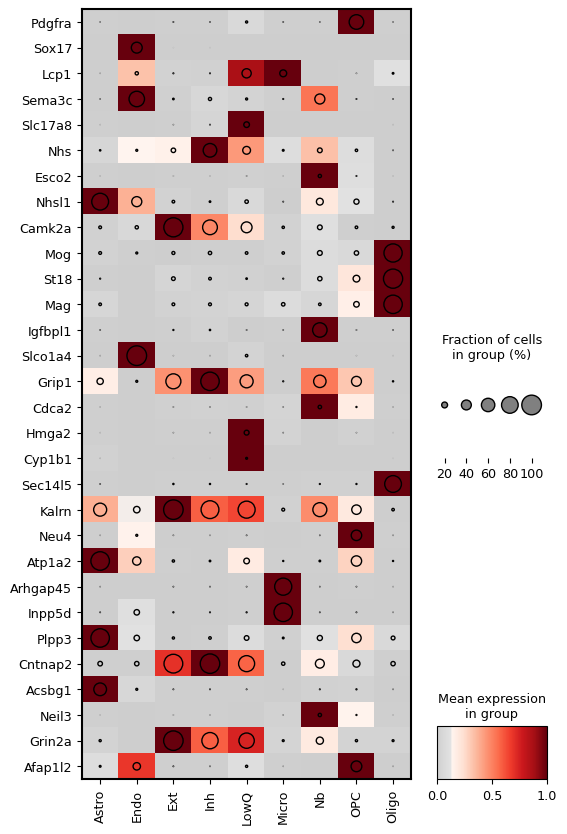

In [22]:
matplotlib.rcdefaults()
matplotlib.rcParams.update({'font.size': 11})
ax = sc.pl.DotPlot(obj,
                   selectedGenes,
                   groupby="Cell sub annotation",
                   standard_scale='var',
                   use_raw=True,
                   figsize=(6,10),
                   linewidths=2).style(cmap=mymap, color_on='square', grid=True, dot_edge_lw=1)
ax.swap_axes(swap_axes=True)
# ax.show()

ax.savefig("Figures/RankCorr_top30.pdf")

# Elapsed time

In [23]:
print("%d genes across %s cells"%(obj.n_vars, obj.n_obs))

31053 genes across 39583 cells


In [24]:
print('Elapsed time (s): ', e-s)

Elapsed time (s):  134.0904393196106
